<a href="https://colab.research.google.com/github/oreomcflurryyy/statistical-learning-survival/blob/main/survival_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifelines
!pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=92feeca4b60c8cfe99615a2445b78af3fffd9e12a6ce6d6d8c1b2eef12ff06e6
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 47.3 MB/s eta 0:00:00
  Attempting u

In [2]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ISLP.models import ModelSpec as MS
from ISLP import load_data

In [3]:
from lifelines import \
     (KaplanMeierFitter,
      CoxPHFitter)
from lifelines.statistics import \
     (logrank_test,
      multivariate_logrank_test)
from ISLP.survival import sim_time

#####This exercise focuses on the brain tumor data, which is included in the ISLP library.

#####(a) Plot the Kaplan-Meier survival curve with ±1 standard error bands, using the KaplanMeierFitter( ) estimator in the lifelines package.

In [4]:
BrainCancer = load_data('BrainCancer')
BrainCancer.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

In [5]:
BrainCancer['status'].value_counts()

,count
status,
0,53
1,35


<Axes: xlabel='timeline'>

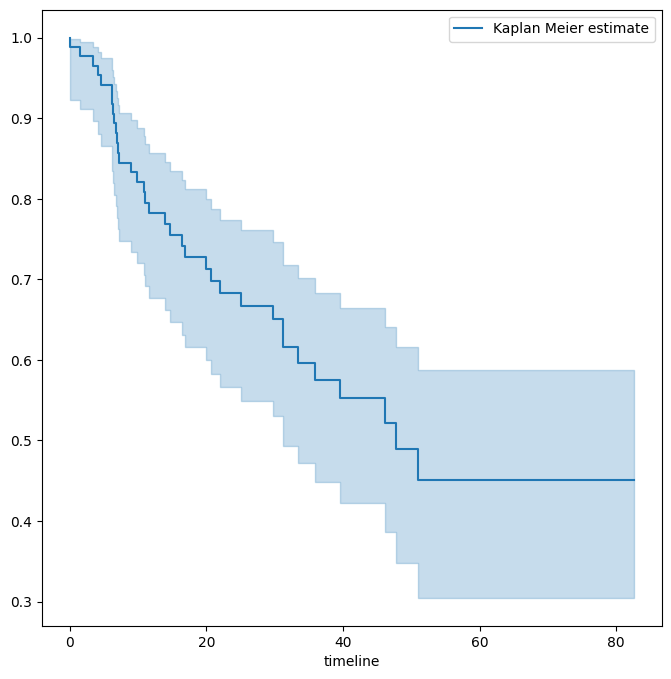

In [6]:
fig, ax = subplots(figsize=(8,8))
km = KaplanMeierFitter()
km_brain = km.fit(BrainCancer['time'], BrainCancer['status'])
km_brain.plot(label='Kaplan Meier estimate', ci_show=True, ax=ax)

#####(b) Draw a bootstrap sample of size n = 88 from the pairs (yi, δi), and compute the resulting Kaplan-Meier survival curve. Repeat this process B = 200 times. Use the results to obtain an estimate of the standard error of the Kaplan-Meier survival curve at each timepoint. Compare this to the standard errors obtained in (a).

In [7]:
survival_function = km.survival_function_
confidence_intervals = km.confidence_interval_
standard_errors = (confidence_intervals.iloc[:, 1] - confidence_intervals.iloc[:, 0]) / (2 * 1.96)

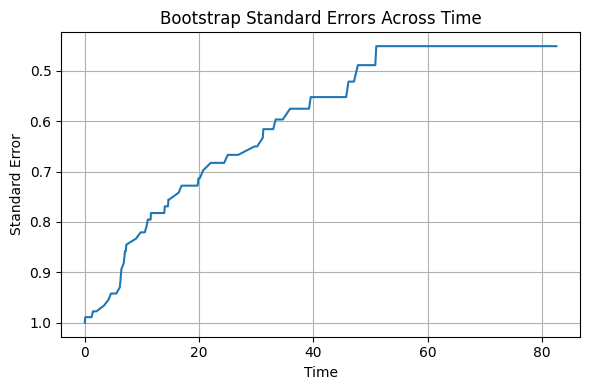


Standard Error Analysis:
Mean Standard Error: 0.0508
Median Standard Error: 0.0531
Max Standard Error: 0.0721
Min Standard Error: 0.0000


In [8]:
# Visualize standard errors across time
plt.figure(figsize=(6, 4))
plt.plot(standard_errors.index, survival_function['KM_estimate'])
plt.title('Bootstrap Standard Errors Across Time')
plt.xlabel('Time')
plt.ylabel('Standard Error')
plt.grid(True)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

# Standard error analysis
print("\nStandard Error Analysis:")
print(f"Mean Standard Error: {np.mean(standard_errors):.4f}")
print(f"Median Standard Error: {np.median(standard_errors):.4f}")
print(f"Max Standard Error: {np.max(standard_errors):.4f}")
print(f"Min Standard Error: {np.min(standard_errors):.4f}")

In [9]:
def bootstrap_kaplan_meier(data, n_bootstrap=200, sample_size=88):
    """
    Perform bootstrap resampling of Kaplan-Meier survival curve

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with 'time' and 'event' columns
    n_bootstrap : int
        Number of bootstrap resamples
    sample_size : int
        Size of each bootstrap sample

    Returns:
    --------
    bootstrap_survival_curves : list
        List of survival curves from bootstrap samples
    common_timeline : numpy.ndarray
        Common time points for all bootstrap samples
    """

    bootstrap_survival_curves = []
    bootstrap_timelines = []

    for _ in range(n_bootstrap):
        bootstrap_sample = data.sample(n=sample_size, replace=True)
        kmf = KaplanMeierFitter()
        kmf.fit(bootstrap_sample['time'], bootstrap_sample['event'])

        bootstrap_survival_curves.append(kmf.survival_function_.values.flatten())
        bootstrap_timelines.append(kmf.timeline)

    common_timeline = np.sort(np.unique(np.concatenate(bootstrap_timelines)))
    interpolated_survival_curves = []
    for curve, timeline in zip(bootstrap_survival_curves, bootstrap_timelines):
        interpolated_curve = np.interp(
            common_timeline,
            timeline,
            curve
        )
        interpolated_survival_curves.append(interpolated_curve)

    return interpolated_survival_curves, common_timeline

In [10]:
def analyze_bootstrap_results(original_data, bootstrap_survival_curves, common_timeline):
    """
    Analyze bootstrap results and compute standard errors

    Parameters:
    -----------
    original_data : pandas.DataFrame
        Original survival data
    bootstrap_survival_curves : list
        Survival curves from bootstrap samples
    common_timeline : numpy.ndarray
        Common time points

    Returns:
    --------
    dict: Containing analysis results
    """

    bootstrap_std_errors = np.std(bootstrap_survival_curves, axis=0)
    km = KaplanMeierFitter()
    km.fit(original_data['time'], original_data['event'])
    original_survival = np.interp(
        common_timeline,
        km.timeline,
        km.survival_function_.values.flatten()
    )

    # Visualization
    plt.figure(figsize=(8, 8))
    plt.plot(common_timeline, original_survival,
             label='Original KM Curve')
    plt.fill_between(
        common_timeline,
        original_survival - bootstrap_std_errors,
        original_survival + bootstrap_std_errors,
        alpha=0.2,
        color='gray',
        label='±1 Bootstrap SE'
    )
    plt.title('Kaplan-Meier Survival Curve with Bootstrap Standard Errors')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Standard error analysis
    print("\nBootstrap Standard Error Analysis:")
    print(f"Mean Standard Error: {np.mean(bootstrap_std_errors):.4f}")
    print(f"Median Standard Error: {np.median(bootstrap_std_errors):.4f}")
    print(f"Max Standard Error: {np.max(bootstrap_std_errors):.4f}")
    print(f"Min Standard Error: {np.min(bootstrap_std_errors):.4f}\n")

    # Visualize standard errors across time
    plt.figure(figsize=(6, 4))
    plt.plot(common_timeline, bootstrap_std_errors)
    plt.title('Bootstrap Standard Errors Across Time')
    plt.xlabel('Time')
    plt.ylabel('Standard Error')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'original_survival': original_survival,
        'bootstrap_std_errors': bootstrap_std_errors,
        'common_timeline': common_timeline
    }


In [11]:
def generate_survival_data():
    """
    Generate simulated survival data

    Parameters:
    -----------
    data : pandas.DataFrame
        Original survival data
    n : int
        Sample size

    Returns:
    --------
    pandas.DataFrame
        Simulated survival data
    """

    return pd.DataFrame({
        'time': BrainCancer['time'],
        'event': BrainCancer['status']
    })

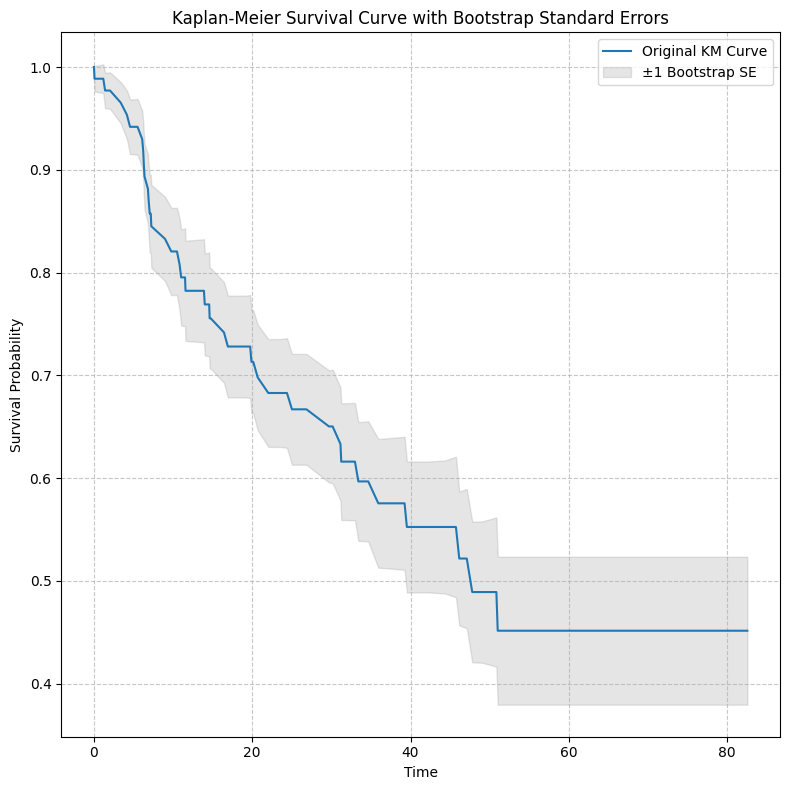


Bootstrap Standard Error Analysis:
Mean Standard Error: 0.0506
Median Standard Error: 0.0524
Max Standard Error: 0.0725
Min Standard Error: 0.0000



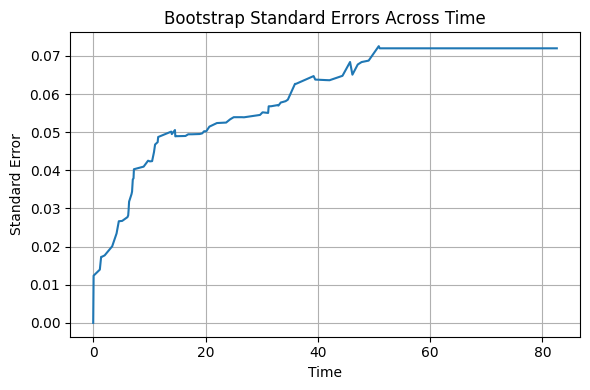


Detailed Bootstrap Analysis:
Number of Bootstrap Samples: 200
Common Timeline Length: 87


In [12]:
survival_data = generate_survival_data()
bootstrap_survival_curves, common_timeline = bootstrap_kaplan_meier(
    survival_data,
    n_bootstrap=200,
    sample_size=88
    )

bootstrap_results = analyze_bootstrap_results(
    survival_data,
    bootstrap_survival_curves,
    common_timeline
    )

print("\nDetailed Bootstrap Analysis:")
print("Number of Bootstrap Samples:", len(bootstrap_survival_curves))
print("Common Timeline Length:", len(common_timeline))

#####(c) Fit a Cox proportional hazards model that uses all of the predictors to predict survival. Summarize the main findings.

In [19]:
coxph = CoxPHFitter
cleaned = BrainCancer.dropna()
all_MS = MS(cleaned.columns, intercept=False)
all_df = all_MS.fit_transform(cleaned)
fit_all = coxph().fit(all_df,
                      'time',
                      'status')
fit_all.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
sex[Male],0.141430,0.358518,0.693223
diagnosis[LG glioma],-1.252333,0.579038,0.030558
diagnosis[Meningioma],-2.204363,0.458164,0.000001
diagnosis[Other],-1.338469,0.628765,0.033277
loc[Supratentorial],0.410540,0.702042,0.558696
ki,-0.057690,0.021013,0.006043
gtv,0.035695,0.022072,0.105833
stereo[SRT],0.184147,0.598790,0.758439


 The `diagnosis` variable has been coded so that the baseline
corresponds to HG glioma. The results indicate that the risk associated with HG glioma
is more than eight times (i.e. $e^{2.15}=8.62$) the risk associated
with meningioma. In other words, after adjusting for the other
predictors, patients with HG glioma have much worse survival compared
to those with meningioma.  In addition, larger values of the Karnofsky
index, `ki`, are associated with lower risk, i.e. longer survival.

#####(d) Stratify the data by the value of ki. (Since only one observation has ki==40, you can group that observation together with the observations that have ki==60.) Plot Kaplan-Meier survival curves for each of the five strata, adjusted for the other predictors.

In [20]:
BrainCancer['ki'] = BrainCancer['ki'].replace(40, 60)
levels = BrainCancer['ki'].unique()
def representative(series):
    if hasattr(series.dtype, 'categories'):
        return pd.Series.mode(series)
    else:
        return series.mean()
modal_data = BrainCancer.apply(representative, axis=0)
levels

array([ 90,  70,  80, 100,  60])

In [21]:
modal_df = pd.DataFrame(
              [modal_data.iloc[0] for _ in range(len(levels))])
modal_df['ki'] = levels
modal_df

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Supratentorial,90,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,70,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,80,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,100,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,60,8.687011,SRT,0.402299,27.188621


In [24]:
modal_X = all_MS.transform(modal_df)
modal_X.index = levels
modal_X

,sex[Male],diagnosis[LG glioma],diagnosis[Meningioma],diagnosis[Other],loc[Supratentorial],ki,gtv,stereo[SRT],status,time
90,0.0,0.0,1.0,0.0,1.0,90,8.687011,1.0,0.402299,27.188621
70,0.0,0.0,1.0,0.0,1.0,70,8.687011,1.0,0.402299,27.188621
80,0.0,0.0,1.0,0.0,1.0,80,8.687011,1.0,0.402299,27.188621
100,0.0,0.0,1.0,0.0,1.0,100,8.687011,1.0,0.402299,27.188621
60,0.0,0.0,1.0,0.0,1.0,60,8.687011,1.0,0.402299,27.188621


In [23]:
predicted_survival = fit_all.predict_survival_function(modal_X)
predicted_survival

,90,70,80,100,60
0.07,0.998570,0.995473,0.997455,0.999197,0.991954
1.18,0.998570,0.995473,0.997455,0.999197,0.991954
1.41,0.996944,0.990343,0.994565,0.998282,0.982871
1.54,0.996944,0.990343,0.994565,0.998282,0.982871
2.03,0.996944,0.990343,0.994565,0.998282,0.982871
...,...,...,...,...,...
65.02,0.802233,0.497290,0.675469,0.883592,0.288276
67.38,0.802233,0.497290,0.675469,0.883592,0.288276
73.74,0.802233,0.497290,0.675469,0.883592,0.288276
78.75,0.802233,0.497290,0.675469,0.883592,0.288276


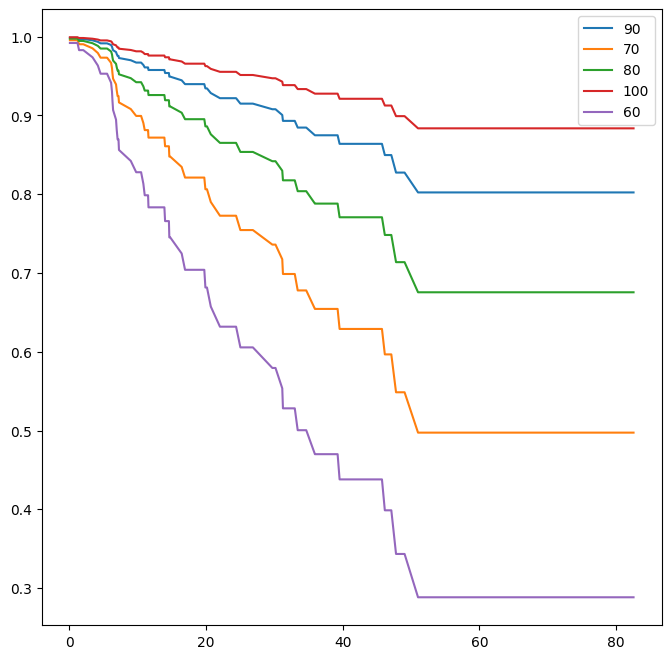

In [25]:
fig, ax = subplots(figsize=(8, 8))
predicted_survival.plot(ax=ax);